## Постановка задачи
Многоклассовая классификация новостей

**Названия столбцов с пояснением:**
- **Title:** Заголловок новости
- **Description:** Описание новости.
- **Class Index:** Тема новости - Таргет (1 — World/Politics, 2 — Sports, 3 — Business, 4 — Sci/Tech).

In [2]:
# Автоматическая перезагрузка модулей при изменении
# Это позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2


In [3]:
# Импорт необходимых библиотек для анализа данных
import pandas as pd  # для работы с табличными данными
import numpy as np   # для математических операций
import random        # для работы с генератором случайных чисел
import html
import string

# Импорт пользовательских модулей с функциями для анализа
from helper import *  # вспомогательные функции для обработки данных
from plots import *   # функции для визуализации
from nlp import *     # функции для обработки естественного языка
import re


In [4]:
# Фиксация состояния генератора псевдослучайных чисел для воспроизводимости результатов
# Это критически важно для машинного обучения - результаты должны быть воспроизводимы
SEED = 42 # можно указать любое число
np.random.seed(SEED)  # для numpy операций
random.seed(SEED)     # для стандартного модуля random


## 1. Изучение структуры данных

**Цель:** Понять общую структуру датасета, количество записей, типы данных и качество информации.
Это первый и самый важный этап любого анализа данных - без понимания структуры невозможно корректно проводить дальнейшую обработку.


In [ ]:
# Загружаем предобработанные данные из CSV файла
df = pd.read_csv('data/data.csv')


In [ ]:
# Выводим общую информацию о структуре датасета:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


## 2. Проверка на корректность и качество данных

**Цель:** Выявить проблемы с данными, которые могут повлиять на качество анализа и моделирования.
Проверяем на дубликаты, пропущенные значения и аномальные записи.


### 2.1 Проверка на дубликаты

**Логика:** Дублированные записи могут искажать результаты анализа и обучения модели.
Если одна и та же вакансия встречается несколько раз, это может привести к переобучению.


In [7]:
# Подсчет числа полностью дублированных строк
# Результат: 0 означает, что дубликатов нет - это хорошо для качества данных
df.duplicated().sum()


np.int64(0)

### 2.2 Пропущенные значения

**Логика:** Пропущенные значения могут нарушить работу алгоритмов машинного обучения.
Нужно понять, есть ли пропуски и как они распределены по столбцам.


In [8]:
# Выводим число пропущенных значений по каждому столбцу
# Результат: все значения равны 0, что означает отсутствие пропусков - отличное качество данных
df.isnull().sum()


Class Index    0
Title          0
Description    0
dtype: int64

In [9]:
# Анализ описаний (менее 300 символов)
short_texts = df[df['Description'].str.len() < 300]
short_texts['Description'].value_counts()

Description
With the economy slowly turning up, upgrading hardware has been on businesses radar in the past 12 months as their number two priority.                                                                                                                15
Most IT Managers won #39;t question the importance of security, but this priority has been sliding between the third and fourth most important focus for companies.                                                                                    11
#NAME?                                                                                                                                                                                                                                                  9
This fourth priority #39;s main focus has been enterprise directories as organizations spawn projects around identity infrastructure.                                                                                                         

почти все тексты (112943 из 120000) короче 300 символов — это нормально для новостных описаний и не означает, что они неинформативны. Обнаружены дубликаты текстов и мусорные записи (например, #NAME?, HTML-артефакты вида #39;). Полное удаление всех коротких текстов приведёт к сильной потере данных и нецелесообразно. 

Что нужно будет сделать дальше:
Удалить явный мусор (пустые строки, #NAME?, битые записи).
Очистить HTML-артефакты и спецсимволы.
Отфильтровать только очень короткие тексты (например, < 100 символов), а не все < 300.

In [10]:
# Анализ коротких описаний (менее 100 символов)
short_texts = df[df['Description'].str.len() < 100]
short_texts['Description'].value_counts()

Description
#NAME?                                                                                                 9
The Associated Press By Ted Bridis                                                                     6
The software juggernaut that conquered the desktop is racing to get Windows into your next car.        6
The Associated Press By Rachel Konrad                                                                  3
The SX-8 is the latest incarnation of the high-end but relatively rare "vector" computer breed.        3
                                                                                                      ..
The annual Perseid meteor shower could provide a "spectacular" show, despite a disappointing start.    1
A rapid and accurate test for TB could cut infection rates around the world, say experts.              1
The first request by British scientists to clone human embryos has been granted by experts.            1
Heat waves in the 21st Century will be more

In [11]:
# Проверка сколько дублированных описанний
total_text = len(df)
unique_text = df['Description'].nunique()
duplicates = total_text - unique_text

total_text, unique_text, duplicates

(120000, 118723, 1277)

1277 дублированных Description

In [ ]:
# проверяем сколько одинаковых Description с разными таргетами
dup = df.groupby('Description')['Class Index'].nunique()
conflicts = dup[dup > 1]
len(conflicts)

98

In [13]:
# Удаляем строки с описанием "Unknown" - это неинформативные записи
# Такие записи не несут смысловой нагрузки для классификации
df = df[df['Description'] != 'Unknown']


In [14]:
# Анализ длинных заголовков (более 100 символов)
# Слишком длинные заголовки могут содержать избыточную информацию или быть некорректными
long_titles = df[df['Title'].str.len() > 100]
long_titles['Title'].value_counts()


Title
Not All Jobs Belong To The White Man: Asian Minorities, Affirmative Action, And The Quest For Parity At Work           1
News: Droughts Like 1930s Dust Bowl May Have Been Unexceptional in Prehistoric Times, New Study Suggests               1
Attachmate Heightens Security, Centralises Management and Brings Microsoft Usability to Host Access with EXTRA! ...    1
 quot;Microsoft #39;s Actions Validate Our Linux Strategy Every Day, quot; Says &lt;b&gt;...&lt;/b&gt;                 1
Edward C. Baig: Personal Tech - Express takes digital music a step further, but it's no iPod (USATODAY.com)            1
In the  #39;Not For Long #39; league, the  #39;Skins #39; Joe Gibbs has missed an &lt;b&gt;...&lt;/b&gt;               1
Blessing or Curse? Top Newspaper Editors Examine Blogs' Role in the '60 Minutes' Uproar (Editor and Publisher)         1
Andrew Kantor: CyberSpeak - Linux takes a step (a small one) toward desktop acceptance (USATODAY.com)                  1
Digital music  #39;niche #

## 3. Детальное изучение признаков (и таргета)

**Цель:** Глубокий анализ каждого признака для понимания их информативности и распределения.
Это поможет выбрать правильные методы предобработки и понять, какие признаки наиболее важны для классификации.


In [6]:
# Создаем копию датасета для EDA, чтобы не изменять исходные данные
# Это позволяет безопасно экспериментировать с данными
df_EDA = df.copy()


### 3.1. Таргет (целевая переменная)

**Логика:** Анализ распределения целевой переменной критически важен для понимания задачи.
Нужно проверить баланс классов - если один класс сильно преобладает, это может потребовать специальных подходов.


In [16]:
# Анализируем распределение целевой переменной (Class Index)
#  1-World, 2-Sports, 3-Business, 4-Sci/Tech
# Смотрим, насколько сбалансированы классы
df_EDA['Class Index'].value_counts()


Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

### 3.2. Анализ заголовков (Title)


In [17]:
# Создаем признак длины заголовка в символах
# Длина текста может быть важным признаком для классификации
df_EDA['title_char_length'] = df_EDA['Title'].str.len()

In [18]:
# Статистическое описание длины заголовков
# Видим среднюю, минимальную, максимальную длину и квартили
df_EDA['title_char_length'].describe()


count    120000.000000
mean         42.071508
std          13.569405
min           6.000000
25%          33.000000
50%          41.000000
75%          49.000000
max         115.000000
Name: title_char_length, dtype: float64

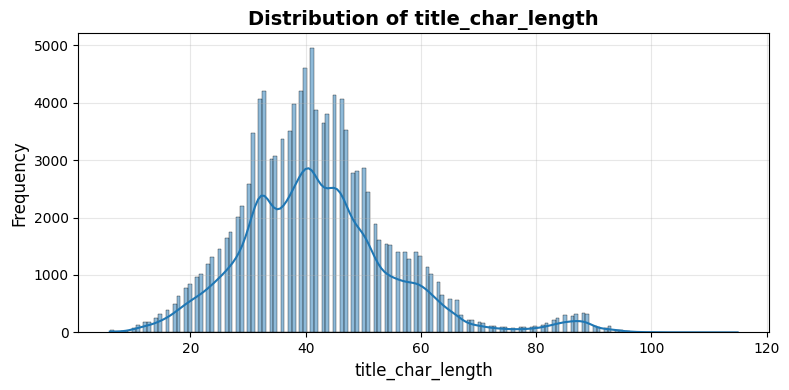

In [19]:
# Визуализируем распределение длины заголовков
# Гистограмма поможет понять, как распределена длина текстов
plot_hist_numeric(df_EDA, 'title_char_length')


In [8]:
# Токенизация заголовков
df_EDA['title_tokenized_words'] = df_EDA['Title'].apply(tokenize_words)

# Длина заголовка в словах
df_EDA['title_tokenized_words_len'] = df_EDA['title_tokenized_words'].apply(len)

In [9]:
# Подсчет частотности токенов в заголовках
# Удаляем стоп-слова и пунктуацию, приводим к нижнему регистру для корректного подсчета
# Это поможет выявить наиболее частые слова в заголовках
stopwords, punctuation = get_default_resources()

df_EDA["title_tokens_clean"] = df_EDA["title_tokenized_words"].apply(
    lambda toks: filter_tokens(
        toks,
        to_lower=True,
        remove_stopwords=True,
        remove_punctuation=True,
        stopwords=stopwords,
        punctuation=punctuation,
    )
)

title_token_counts = token_counts(df_EDA["title_tokens_clean"].tolist())
title_token_counts

Counter({'39': 12631,
         's': 12317,
         'ap': 7777,
         'b': 5220,
         'gt': 5200,
         'lt': 5183,
         'reuters': 4262,
         'new': 4033,
         'oil': 2533,
         'says': 2404,
         'microsoft': 2348,
         'iraq': 2296,
         'u': 2226,
         '1': 2034,
         'afp': 1967,
         '2': 1728,
         'deal': 1654,
         'china': 1587,
         'stocks': 1467,
         'profit': 1451,
         't': 1428,
         'win': 1370,
         'update': 1317,
         'world': 1287,
         'bush': 1287,
         'talks': 1248,
         'game': 1232,
         'wins': 1230,
         '3': 1182,
         'sales': 1177,
         'report': 1174,
         'prices': 1164,
         'ibm': 1164,
         'security': 1120,
         'open': 1081,
         'google': 1024,
         'eu': 1017,
         'com': 966,
         'japan': 965,
         'set': 933,
         'india': 929,
         'gets': 913,
         'court': 886,
         'record': 874

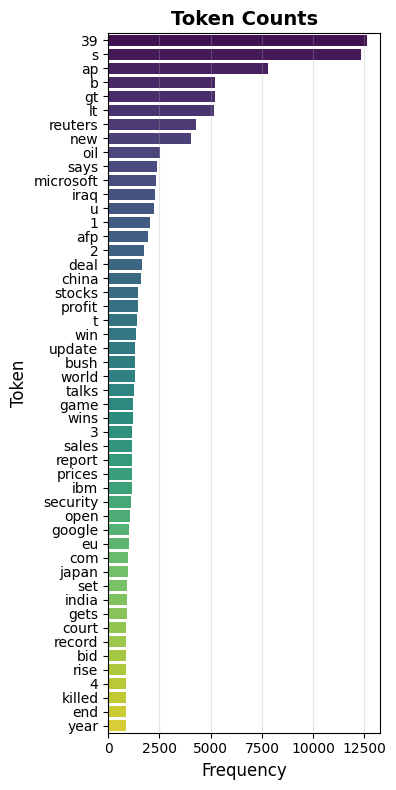

In [24]:
# Визуализация топ-50 самых частых токенов в заголовках
# Столбчатая диаграмма поможет быстро увидеть ключевые слова
barplot(
    pd.Series(title_token_counts).sort_values(ascending=False),
    title="Token Counts",
    ylabel="Token",
    top_n=50,
    figsize=(4, 8)
)


доминируют спецсимволы, например: 39, lt, gt, одиночные буквы (b, t, u), короткие фрагменты (ap, afp, reuters). Это признак того, что в заголовках присутствуют остатки HTML/тегов/кодировок

числа встречаются часто и могут быть либо частью дат/индексов, либо артефактами. В текущем виде они занимают место смысловых токенов. В дальнейшем можно заменить числа на специальный токен.

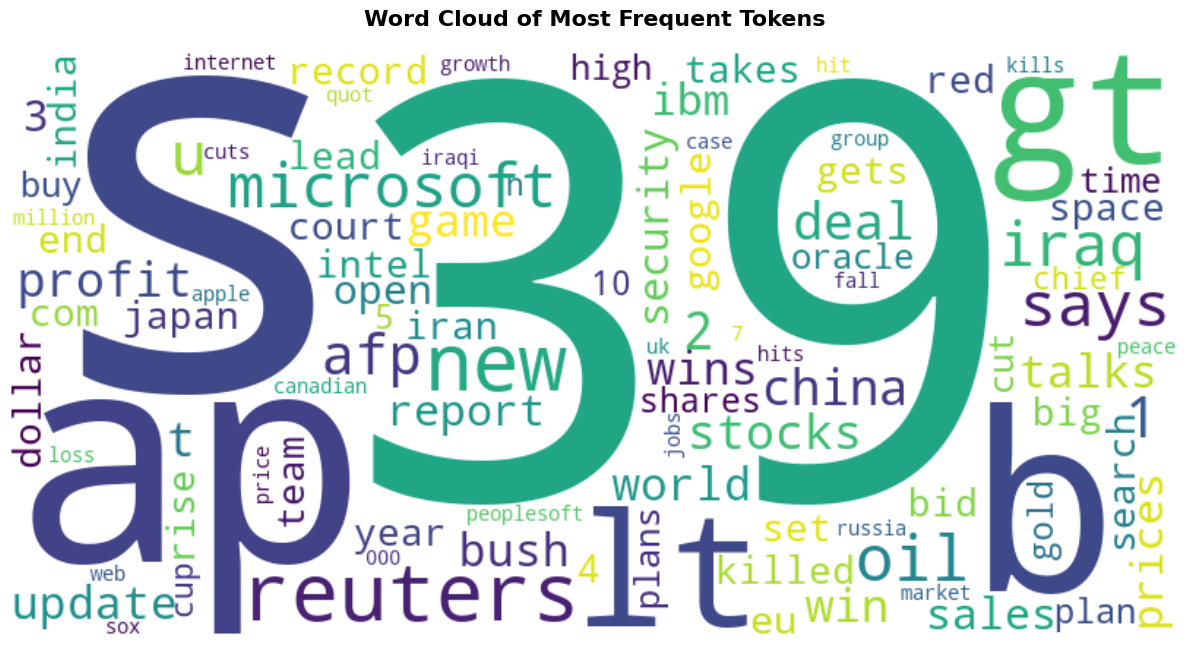

In [26]:
# Облако слов для визуализации частотности токенов
# Размер слова пропорционален его частотности - интуитивно понятная визуализация
plot_wordcloud(
    pd.Series(title_token_counts).sort_values(ascending=False),
    title="Word Cloud of Most Frequent Tokens",
    max_words=100
)


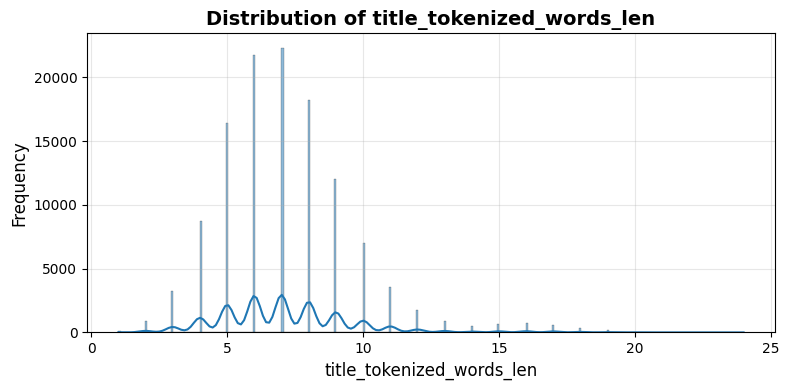

In [27]:
# Распределение количества токенов в заголовках
# Помогает понять, сколько слов в среднем содержит заголовок
plot_hist_numeric(df_EDA, 'title_tokenized_words_len')


In [10]:
# Очистка токенов: удаляем стоп-слова и знаки пунктуации
# Это подготовка для анализа важности токенов для классификации
stopwords, punctuation = get_default_resources()

df_EDA["title_tokenized_words_clean"] = (
    df_EDA["title_tokenized_words"]
    .apply(ensure_tokens)
    .apply(lambda tokens: filter_tokens(
        tokens,
        to_lower=True,
        remove_stopwords=True,
        remove_punctuation=True,
        stopwords=stopwords,
        punctuation=punctuation,
    ))
)


In [ ]:
# Анализ важности токенов для классификации с помощью ANOVA F-test
# n=3: анализируем 1-граммы, 2-граммы и 3-граммы
# min_count=50: учитываем только токены, встречающиеся минимум 50 раз
# Это поможет выявить наиболее информативные для классификации слова и фразы
title_token_counts = count_based_analysis(
    tokenized_texts=df_EDA["title_tokenized_words_clean"],  
    y=df_EDA["Class Index"].astype(int),
    n=1,
    metric="anova_f",
    min_df=50     
)


In [34]:
# Выводим топ-5 наиболее важных для классификации токенов в заголовках
# Чем выше значение метрики, тем важнее токен для различения классов
title_token_counts.head(5)


,token,score,total_count,count_1,freq_1,count_2,freq_2,count_3,freq_3,count_4,freq_4
0,iraq,2051.406399,2296,2148,0.071600,9,0.000300,119,0.003967,20,0.000667
1,oil,1867.742062,2533,272,0.009067,8,0.000267,2218,0.073933,35,0.001167
2,microsoft,1668.522318,2348,11,0.000367,0,0.000000,328,0.010933,2009,0.066967
3,profit,1137.305347,1451,26,0.000867,5,0.000167,1305,0.043500,115,0.003833
4,stocks,1017.596036,1467,173,0.005767,1,0.000033,1267,0.042233,26,0.000867


In [35]:
title_counts_2 = count_based_analysis(
    tokenized_texts=df_EDA["title_tokenized_words_clean"],
    y=df_EDA["Class Index"].astype(int),
    n=2,
    metric="anova_f",
    top_k=300,
    min_df=50
)

title_counts_3 = count_based_analysis(
    tokenized_texts=df_EDA["title_tokenized_words_clean"],
    y=df_EDA["Class Index"].astype(int),
    n=3,
    metric="anova_f",
    top_k=300,
    min_df=50
)

In [36]:
title_counts_2.head(5)

,token,score,total_count,count_1,freq_1,count_2,freq_2,count_3,freq_3,count_4,freq_4
0,oil prices,490.871353,654,69,0.002300,0,0.000000,582,0.019400,3,0.000100
1,canadian press,456.166825,452,451,0.015033,0,0.000000,0,0.000000,1,0.000033
2,red sox,363.644091,443,28,0.000933,410,0.013667,3,0.000100,2,0.000067
3,open source,216.526911,228,0,0.000000,0,0.000000,5,0.000167,223,0.007433
4,wal mart,199.823563,251,9,0.000300,1,0.000033,230,0.007667,11,0.000367


In [37]:
title_counts_3.head(5)

,token,score,total_count,count_1,freq_1,count_2,freq_2,count_3,freq_3,count_4,freq_4
0,mount st helens,60.706760,73,5,0.000167,0,0.000000,0,0.000000,68,0.002267
1,crude oil prices,52.529273,67,6,0.000200,0,0.000000,61,0.002033,0,0.000000
2,car bomb kills,50.081803,50,50,0.001667,0,0.000000,0,0.000000,0,0.000000
3,oil prices fall,47.512905,55,3,0.000100,0,0.000000,52,0.001733,0,0.000000
4,lt gt lt,45.079689,2560,853,0.028433,608,0.020267,654,0.021800,445,0.014833


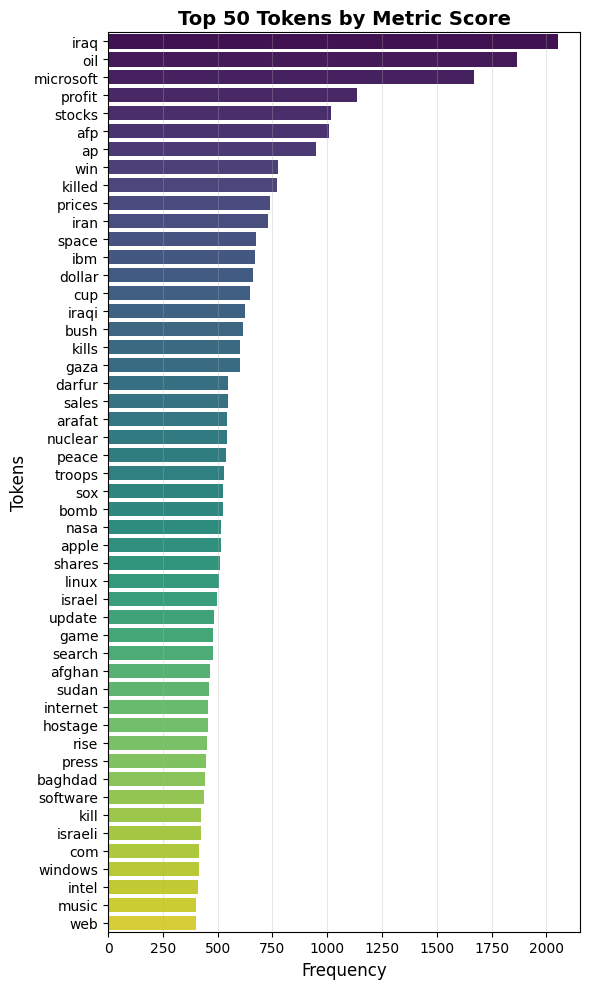

In [39]:
# Визуализация топ-50 токенов по важности для классификации
# Помогает понять, какие слова и фразы лучше всего различают DS и не-DS вакансии
barplot_data_metric = title_token_counts.set_index('token')['score'].head(50)
barplot(barplot_data_metric, 'Top 50 Tokens by Metric Score', 'Tokens', figsize=(6, 10))


### 3.3. Анализ описаний (Description)

**Логика:** Описания вакансий содержат основную информацию о требованиях и обязанностях.
Это самый информативный признак для классификации, поэтому его анализ особенно важен.


In [19]:
# Анализ длины описаний в символах
# Описания обычно длиннее заголовков и содержат больше информации
df_EDA['description_char_length'] = df_EDA['Description'].str.len()


In [20]:
# Статистическое описание длины описаний
# Описания значительно длиннее заголовков, что ожидаемо
df_EDA['description_char_length'].describe()


count    120000.000000
mean        193.388517
std          64.472066
min           6.000000
25%         155.000000
50%         188.000000
75%         219.000000
max         985.000000
Name: description_char_length, dtype: float64

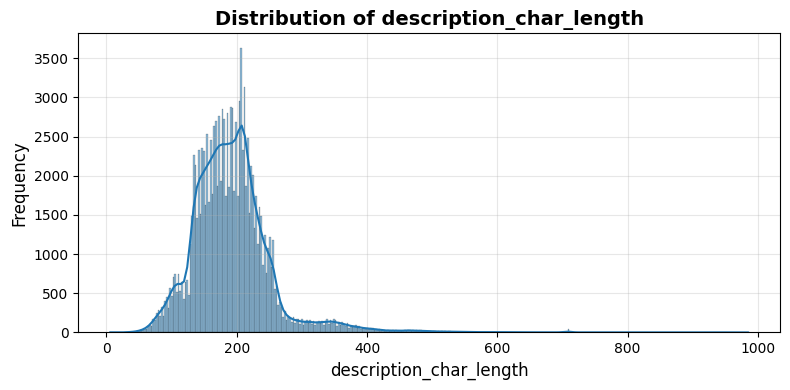

In [21]:
# Распределение длины описаний
# Видим, что большинство описаний довольно длинные (более 1000 символов)
plot_hist_numeric(df_EDA, 'description_char_length')


In [22]:
# Токенизация описаний
# Описания содержат больше токенов, чем заголовки
df_EDA['description_tokenized_words'] = df_EDA['Description'].apply(tokenize_words)
df_EDA['description_tokenized_words_len'] = df_EDA['description_tokenized_words'].apply(len)


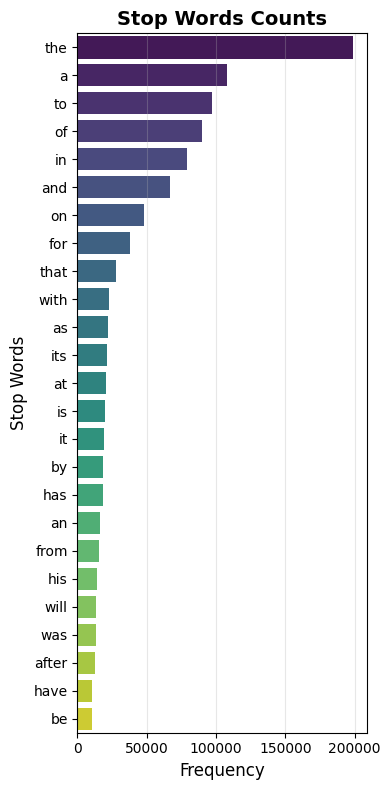

In [23]:
STOPWORDS = get_stopwords_set()

TOK_COL = "description_tokenized_words" 

tokens_series = df_EDA[TOK_COL].apply(ensure_tokens)

stop_words_counts = token_counts(
    tokens_series.apply(lambda toks: [t for t in toks if isinstance(t, str) and t.lower() in STOPWORDS]).tolist()
)

barplot(
    pd.Series(stop_words_counts).sort_values(ascending=False),
    title="Stop Words Counts",
    ylabel="Stop Words",
    top_n=25,
    figsize=(4, 8),
)

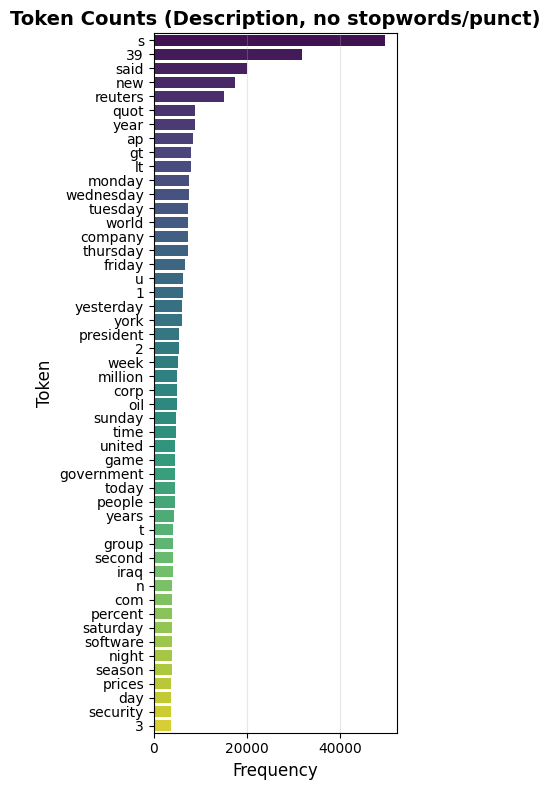

In [24]:
# Подсчет частотности токенов в описаниях (без стоп-слов и пунктуации)
# Это поможет выявить ключевые технические термины и навыки
df_EDA["description_tokens_clean"] = (
    df_EDA[TOK_COL]
    .apply(ensure_tokens)
    .apply(lambda toks: filter_tokens(
        toks,
        to_lower=True,
        remove_stopwords=True,
        remove_punctuation=True,
        stopwords=stopwords,
        punctuation=punctuation,
    ))
)

token_counts_desc = token_counts(df_EDA["description_tokens_clean"].tolist())

barplot(
    pd.Series(token_counts_desc).sort_values(ascending=False),
    title="Token Counts (Description, no stopwords/punct)",
    ylabel="Token",
    top_n=50,
    figsize=(4, 8),
)

Самый частый токен это 39 и s —  мусорный артефакт HTML-кодирования, его нужно удалить на этапе очистки.

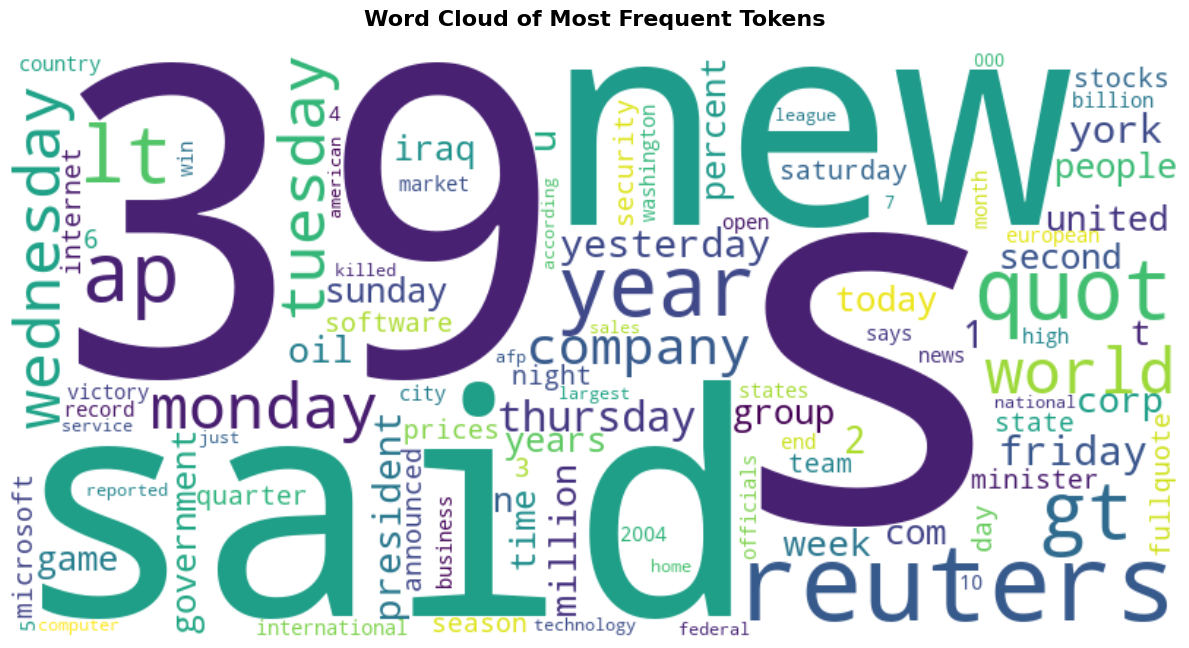

In [16]:
plot_wordcloud(
    pd.Series(token_counts_desc).sort_values(ascending=False),
    title="Word Cloud of Most Frequent Tokens",
    max_words=100
)

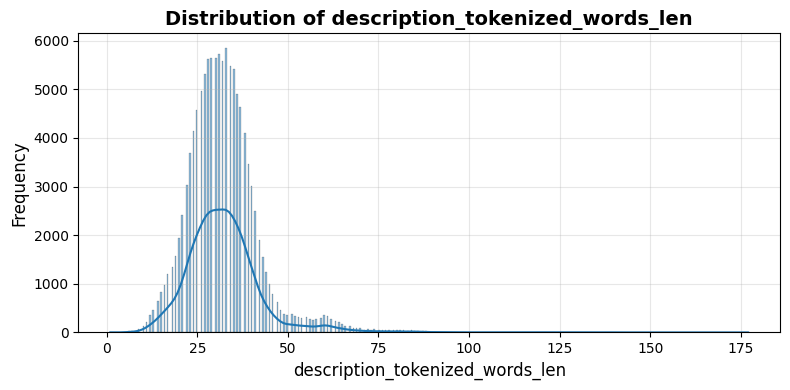

In [38]:
# Распределение количества токенов в описаниях
# Описания содержат значительно больше токенов, чем заголовки
plot_hist_numeric(df_EDA, 'description_tokenized_words_len')


In [25]:
# Очистка токенов описаний: удаляем стоп-слова и пунктуацию
# Подготавливаем данные для анализа важности токенов
df_EDA["description_tokenized_words_clean"] = (
    df_EDA[TOK_COL]
    .apply(ensure_tokens)
    .apply(lambda tokens: filter_tokens(
        tokens,
        to_lower=True,
        remove_stopwords=True,
        remove_punctuation=True,
        stopwords=stopwords,
        punctuation=punctuation,
    ))
)


In [26]:
# Анализ важности токенов в описаниях для классификации
# Это самый важный анализ - выявляем, какие слова и фразы лучше всего различают категории 
# n=3: анализируем 1-граммы, 2-граммы и 3-граммы
title_token_counts = count_based_analysis(
    tokenized_texts=df_EDA["description_tokenized_words_clean"], 
    y=df_EDA["Class Index"].astype(int),
    n=1,
    metric="anova_f",
    min_df=50      
)


In [27]:
# Настраиваем отображение чисел с плавающей точкой для лучшей читаемости
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [28]:
# Выводим результаты анализа важности токенов
# Чем выше значение метрики, тем важнее токен для классификации DS vs не-DS вакансий
title_token_counts.head(20)


,token,score,total_count,count_1,freq_1,count_2,freq_2,count_3,freq_3,count_4,freq_4
0,iraq,2997.76992,4039,3689,0.12297,23,0.00077,270,0.00900,57,0.00190
1,minister,2602.22496,3424,3095,0.10317,31,0.00103,233,0.00777,65,0.00217
2,prices,2498.77379,3743,271,0.00903,7,0.00023,3250,0.10833,215,0.00717
3,oil,2412.91484,5031,747,0.02490,14,0.00047,4168,0.13893,102,0.00340
4,season,2364.91727,3844,93,0.00310,3235,0.10783,335,0.01117,181,0.00603
5,microsoft,2305.14634,3588,14,0.00047,0,0.00000,438,0.01460,3136,0.10453
6,stocks,2284.23314,3485,182,0.00607,3,0.00010,3251,0.10837,49,0.00163
7,president,2195.45049,5504,3955,0.13183,220,0.00733,877,0.02923,452,0.01507
8,league,2178.86280,2620,87,0.00290,2505,0.08350,14,0.00047,14,0.00047
9,killed,2156.33861,2498,2364,0.07880,71,0.00237,17,0.00057,46,0.00153


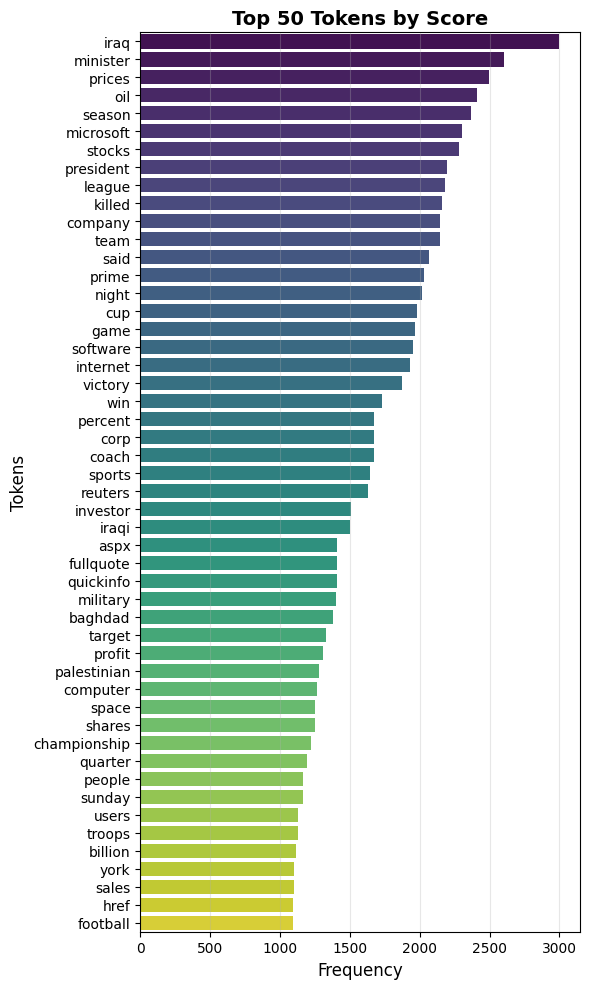

In [29]:
# Визуализация топ-50 наиболее важных для классификации токенов в описаниях
# Это ключевой результат EDA - показывает, какие термины лучше всего различают типы вакансий
barplot_data_score = (
    title_token_counts
    .sort_values("score", ascending=False)
    .set_index("token")["score"]
    .head(50)
)

barplot(
    barplot_data_score,
    title="Top 50 Tokens by Score",
    ylabel="Tokens",
    top_n=50,
    figsize=(6, 10)
)


# Проверка на мусор

In [ ]:
# Проверка "мусора" и артефактов в сырых текстах (HTML/кодировки/служебные токены)
# Цель: быстро понять, есть ли системный шум (lt/gt/amp, странные символы, цифры и т.п.)
TEXT_COL = "Description"  

s = df_EDA[TEXT_COL].fillna("").astype(str)

# Частоты HTML-энтити вида &lt; &gt; &amp; &quot; ...
html_entities = Counter()
for t in s:
    for m in re.findall(r"&[a-zA-Z]+;", t):
        html_entities[m.lower()] += 1

print("Top HTML entities:")
pd.Series(html_entities).sort_values(ascending=False).head(20)

Top HTML entities:


&gt;    7982
&lt;    7977
dtype: int64

In [ ]:
# Частоты "подозрительных" паттернов в токенах после твоей токенизации

TOK_COL = "description_tokenized_words" 

tokens_series = df_EDA[TOK_COL].apply(ensure_tokens)

# считаем частоты токенов (без удаления стопслов/пунктуации — нам важен "мусор")
tok_cnt = token_counts(tokens_series.tolist())

# частые короткие/странные токены (1-2 символа)
short_cnt = {k: v for k, v in tok_cnt.items() if isinstance(k, str) and len(k) <= 2}
print("Top short tokens (len<=2):")
pd.Series(short_cnt).sort_values(ascending=False).head(30)

Top short tokens (len<=2):


a     108264
to     96814
of     89568
in     78754
s      49667
on     48063
39     31874
as     21925
at     20834
is     19993
it     19171
by     18770
an     16575
be     10415
us      9079
he      8624
ap      8499
gt      8031
lt      7999
up      7334
u       6214
1       6192
2       5417
t       4219
no      4180
n       4013
or      3772
3       3640
6       3433
10      3005
dtype: int64

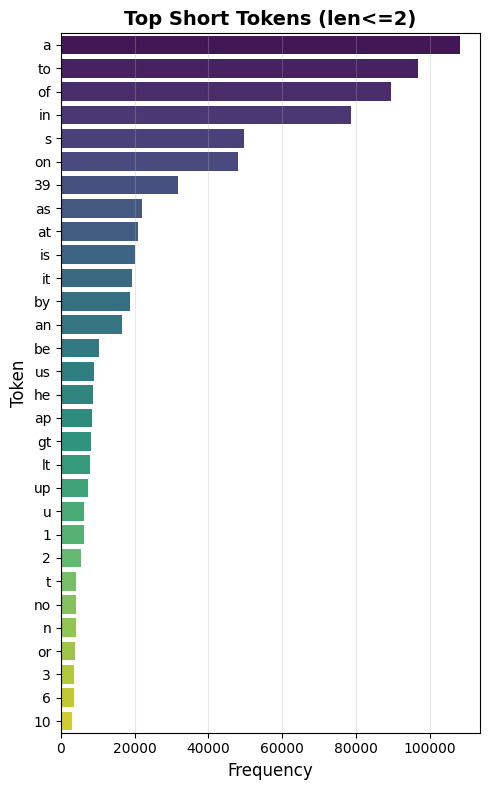

In [51]:
# Визуализация топ коротких токенов (len<=2)
import pandas as pd
from plots import barplot

short_cnt_series = pd.Series(short_cnt).sort_values(ascending=False)
if len(short_cnt_series) > 0:
    barplot(
        short_cnt_series,
        title="Top Short Tokens (len<=2)",
        ylabel="Token",
        top_n=30,
        figsize=(5, 8),
    )
else:
    print("No short tokens found.")


In [ ]:
# "мусорные" токены вида lt/gt/amp/quot и т.п.
suspects = ["lt", "gt", "amp", "quot", "nbsp", "br", "href", "http", "https"]
suspect_counts = {k: tok_cnt.get(k, 0) for k in suspects}

pd.Series(suspect_counts).sort_values(ascending=False)


quot     8941
gt       8031
lt       7999
http     2267
href     2119
amp      1343
br        251
nbsp       71
https       1
dtype: int64

In [53]:
# Доля текстов, где встречаются подозрительные токены (оценка масштаба проблемы)
suspect_set = set(suspects)

def has_suspects(toks):
    return any(t in suspect_set for t in toks)

share = tokens_series.apply(has_suspects).mean()
print(f"Share of samples containing suspect tokens {suspects}: {share:.4%}")

Share of samples containing suspect tokens ['lt', 'gt', 'amp', 'quot', 'nbsp', 'br', 'href', 'http', 'https']: 7.1342%


In [54]:
# Быстрая проверка цифр: доля текстов, где есть цифры (в сыром тексте)
has_digit = s.str.contains(r"\d", regex=True).mean()
print(f"Share of samples containing digits: {has_digit:.4%}")

Share of samples containing digits: 52.5583%
